In [1]:
import sys 
sys.path.append('..')

%load_ext autoreload
import torch
import matplotlib.pyplot as plt
from scipy import signal
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale, Lambda
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from scipy.signal import get_window


from losses import *
from test_utils import *

/home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK3c106IValue23reportToTensorTypeErrorEv
  warn(f"Failed to load image Python extension: {e}")


## 1D Signal Filters

torch.Size([1, 401]) torch.Size([1, 401])


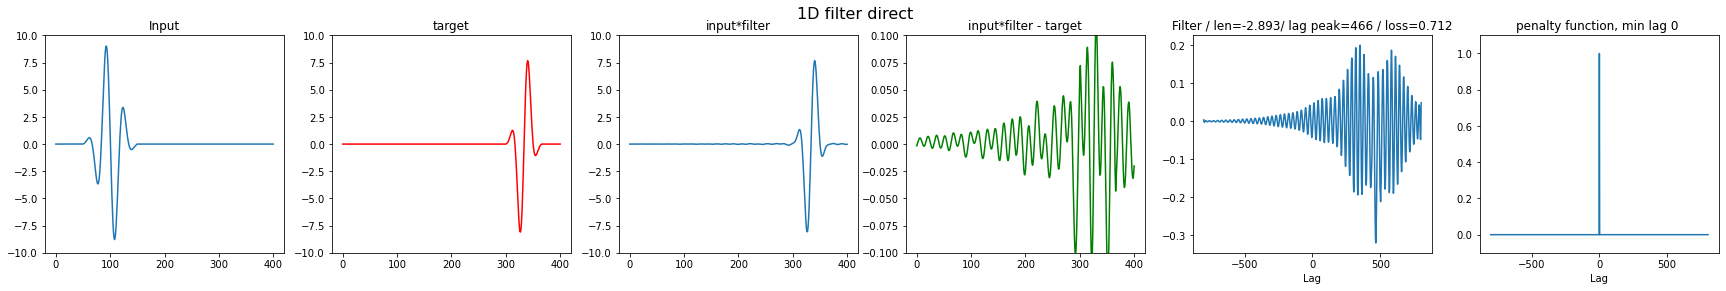

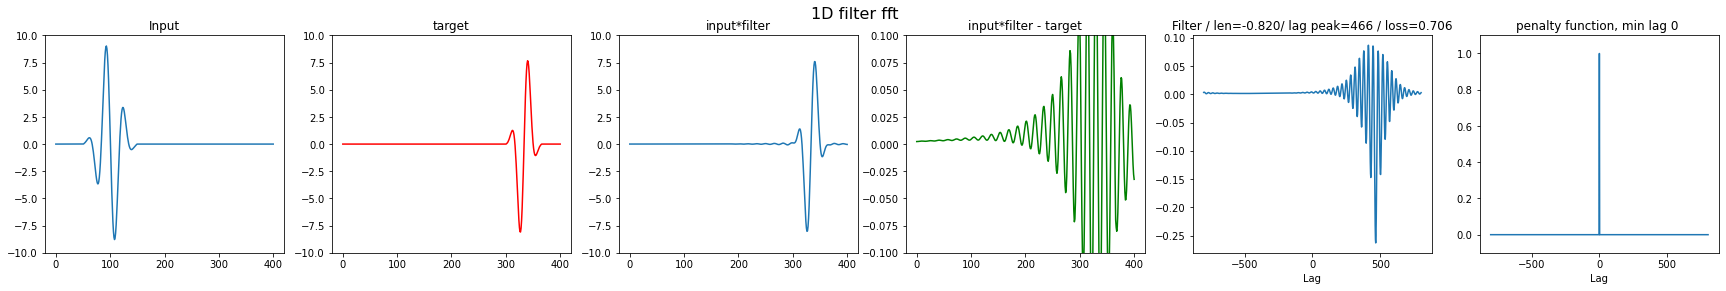

In [2]:
# AWLoss instantiation for testing
aw1d       = AWLoss(epsilon=3e-5, store_filters="unorm", method="direct", filter_dim=1)
aw1dfft    = AWLoss(epsilon=3e-5, store_filters="unorm", method="fft", filter_dim=1)

# 1D burst signal
def tone_burst(dt, centre_freq, n_cycles, n_samples, envelope='gaussian', offset=0, phase=lambda x:0):
    tone_length = n_cycles/centre_freq
    time_array, step = np.linspace(0, tone_length, int(tone_length/dt+1), retstep=True, endpoint=False)
    tone_burst = np.sin(2*np.pi*centre_freq*time_array+2*np.pi*centre_freq*phase(time_array))
    n_tone = tone_burst.shape[0]
    if envelope=='gaussian':
        limit = 3
        window_x = np.linspace(-limit, limit, n_tone)
        window = np.exp(-window_x**2/2)
    elif envelope=='rectangular':
        window = np.ones((tone_burst.shape[0],))
    else:
        raise Exception('Envelope type not implemented')
    tone_burst = np.multiply(tone_burst, window)
    window = get_window(('tukey', 0.05), n_tone, False)
    tone_burst = np.multiply(tone_burst, window)
    signal = np.pad(tone_burst, ((offset, n_samples-offset-n_tone),), mode='constant', constant_values=0)
    return signal

input = np.asarray(10*tone_burst(1e-7, 3e5, 3, 401, offset=50),
                    dtype=np.float32)

target = np.asarray(10*tone_burst(1e-7, 3e5, 2, 401, offset=300),
                    dtype=np.float32)
target = torch.from_numpy(target).unsqueeze(0)
input = torch.from_numpy(input).unsqueeze(0)

print(target.shape, input.shape)

ylim, errylim = 10, 0.1
test_filter_1dsignal(input, target, aw1d, figtitle="{}D filter {}".format(aw1d.filter_dim, aw1d.method), ymin=-ylim, ymax=ylim, errymin=-errylim, errymax=errylim)
test_filter_1dsignal(input, target, aw1dfft, figtitle="{}D filter {}".format(aw1dfft.filter_dim, aw1dfft.method), ymin=-ylim, ymax=ylim, errymin=-errylim, errymax=errylim)

## Single Channel Image Filters

Input: 
	 torch.Size([1, 1, 28, 28]) 0.0 1.0
Target: 
	 torch.Size([1, 1, 28, 28]) 0.0 1.0


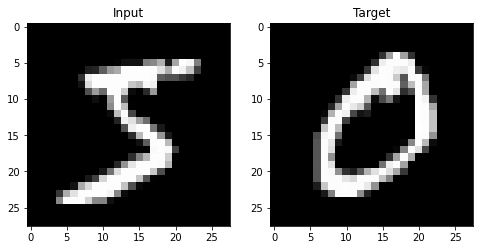

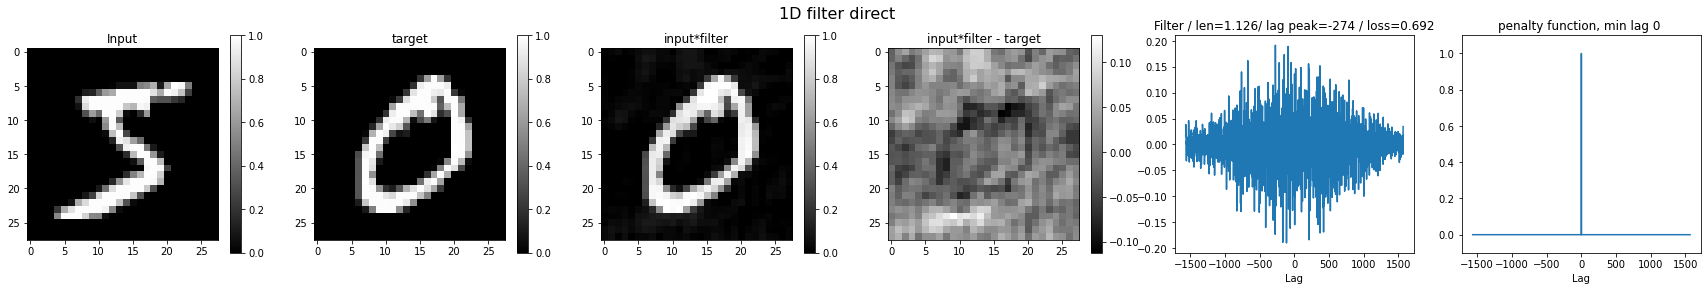

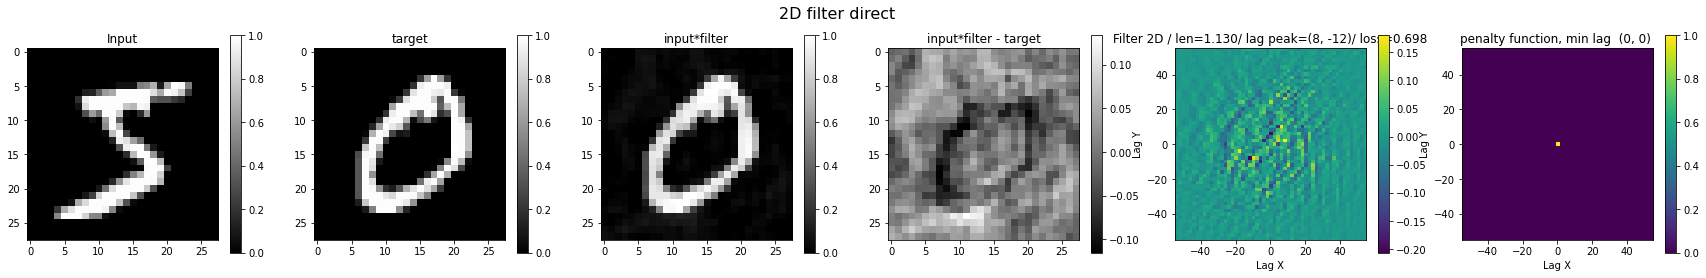

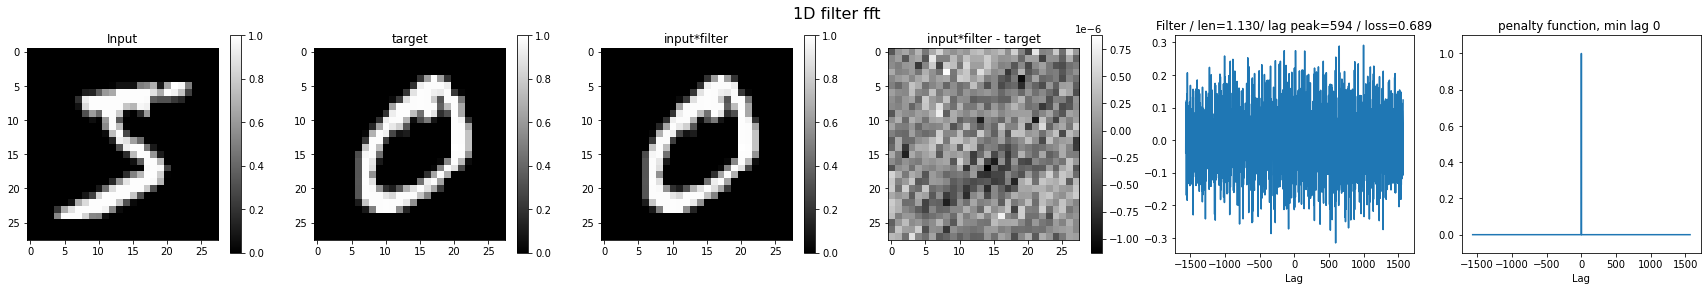

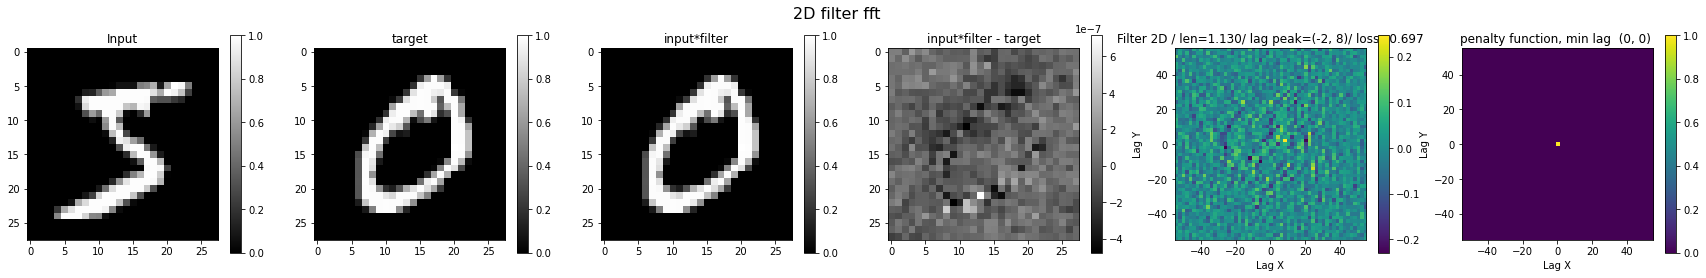

In [3]:
# AWLoss instantiation for testing
epsilon = 3e-15
aw1d    = AWLoss(filter_dim=1, method="direct", epsilon=epsilon, store_filters="unorm")
aw2d    = AWLoss(filter_dim=2, method="direct", epsilon=epsilon, store_filters="unorm")
aw1dfft = AWLoss(filter_dim=1, method="fft",    epsilon=epsilon, store_filters="unorm")
aw2dfft = AWLoss(filter_dim=2, method="fft",    epsilon=epsilon, store_filters="unorm")

# MNIST dataset
train_transform = Compose([
    Resize(28),
    ToTensor(),
])
ds = MNIST("../examples/data/", download=False, train=True, transform=train_transform)

# Input example
input = ds[0][0].unsqueeze(0)
print("Input: \n\t", input.shape, input.min().item(), input.max().item())

# Target example
target = ds[1][0].unsqueeze(0)
print("Target: \n\t", target.shape, target.min().item(), target.max().item())

# Image Dimensions
h, w = input.shape[2], input.shape[3]

# Plot
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(input.squeeze(0).permute(1,2,0), cmap="gray")
ax[0].set_title("Input")
ax[1].imshow(target.squeeze(0).permute(1,2,0), cmap="gray")
ax[1].set_title("Target")
plt.show()

cmap, vmin, vmax, errvmin, errvmax = "gray", 0., 1., None, None
test_filter_img(input, target, aw1d,    figtitle="{}D filter {}".format(aw1d.filter_dim, aw1d.method),    cmap=cmap, vmax=vmax, vmin=vmin, errvmin=errvmin, errvmax=errvmax)
test_filter_img(input, target, aw2d,    figtitle="{}D filter {}".format(aw2d.filter_dim, aw2d.method),    cmap=cmap, vmax=vmax, vmin=vmin, errvmin=errvmin, errvmax=errvmax)
test_filter_img(input, target, aw1dfft, figtitle="{}D filter {}".format(aw1dfft.filter_dim, aw1dfft.method), cmap=cmap, vmax=vmax, vmin=vmin, errvmin=errvmin, errvmax=errvmax)
test_filter_img(input, target, aw2dfft, figtitle="{}D filter {}".format(aw2dfft.filter_dim, aw2dfft.method), cmap=cmap, vmax=vmax, vmin=vmin, errvmin=errvmin, errvmax=errvmax)

## Multichannel Image Filters

Input: 
	 torch.Size([1, 3, 28, 28]) 0.003921568859368563 0.9921568632125854
Target: 
	 torch.Size([1, 3, 28, 28]) 0.04313725605607033 0.9843137264251709


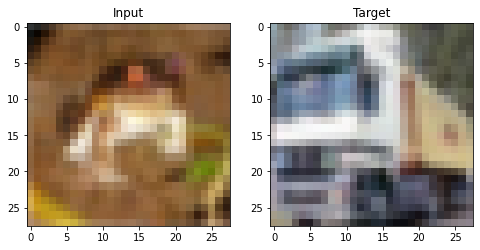

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


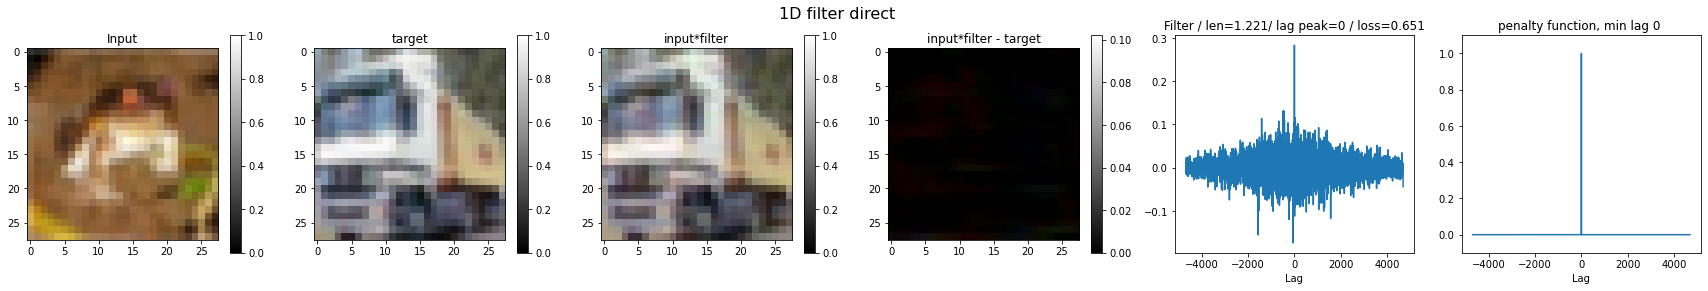

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


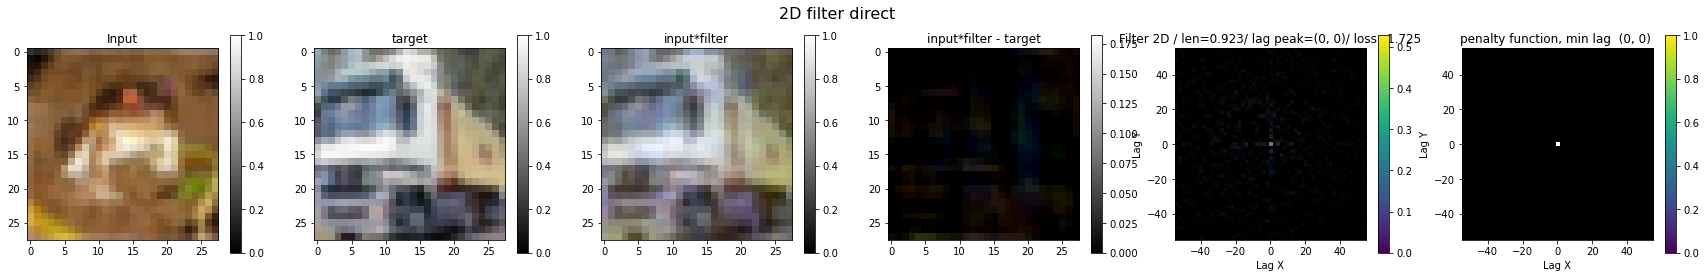

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


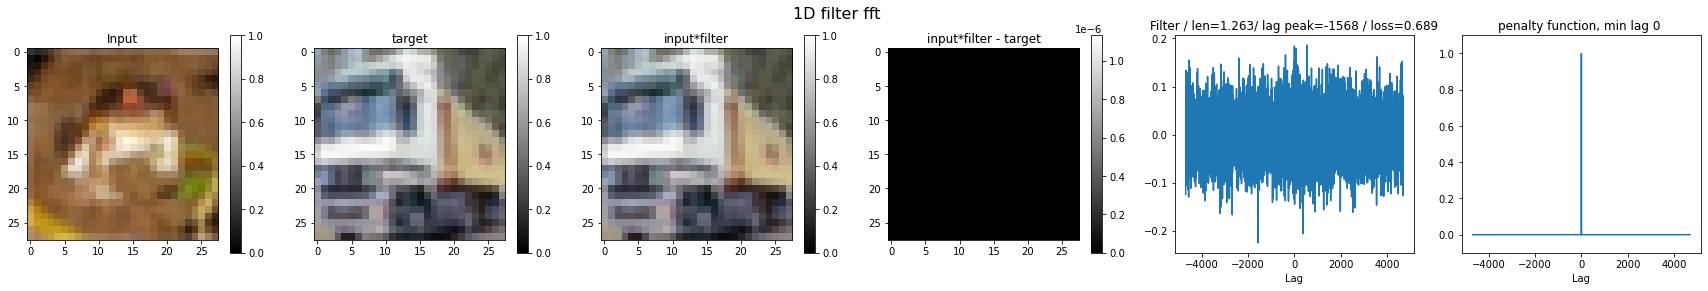

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


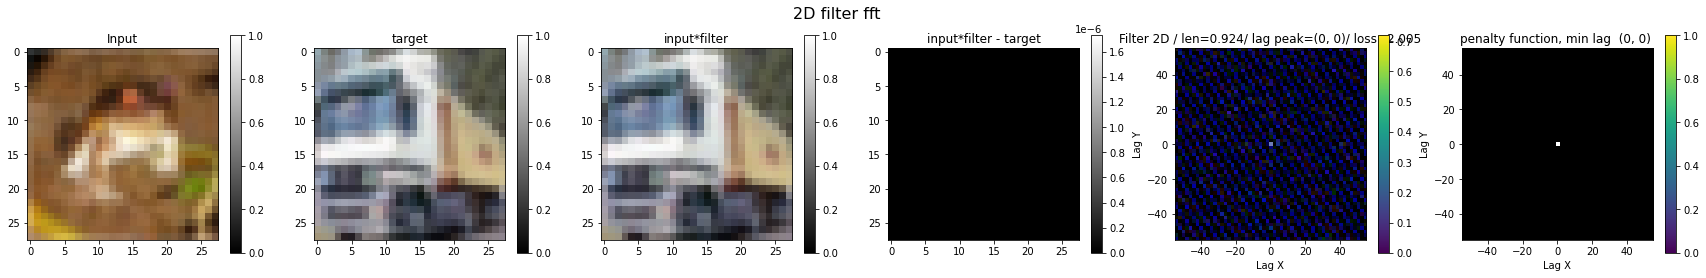

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


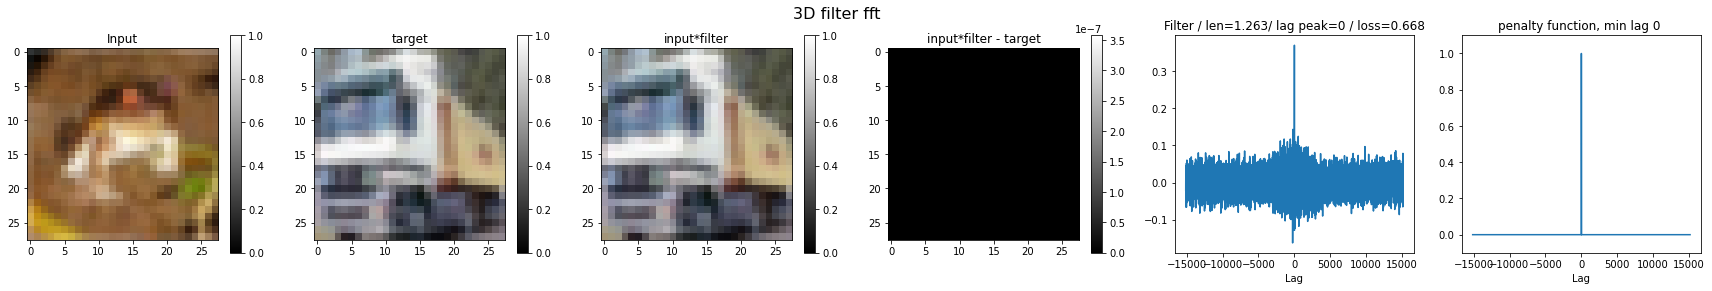

In [4]:
# AWLoss instantiation for testing
epsilon = 3e-15
aw1d    = AWLoss(filter_dim=1, method="direct", epsilon=epsilon, store_filters="unorm")
aw2d    = AWLoss(filter_dim=2, method="direct", epsilon=epsilon, store_filters="unorm")
aw1dfft = AWLoss(filter_dim=1, method="fft",    epsilon=epsilon, store_filters="unorm")
aw2dfft = AWLoss(filter_dim=2, method="fft",    epsilon=epsilon, store_filters="unorm")
aw3dfft = AWLoss(filter_dim=3, method="fft",    epsilon=epsilon, store_filters="unorm")

# CIFAR10 dataset
train_transform = Compose([
    Resize(28),
    ToTensor(),
])
ds = CIFAR10("../examples/data/", download=False, train=True, transform=train_transform)

# Input example
input = ds[0][0].unsqueeze(0)
print("Input: \n\t", input.shape, input.min().item(), input.max().item())

# Target example
target = ds[1][0].unsqueeze(0)
print("Target: \n\t", target.shape, target.min().item(), target.max().item())

# Image Dimensions
h, w = input.shape[2], input.shape[3]

# Plot
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(input.squeeze(0).permute(1,2,0), cmap="gray")
ax[0].set_title("Input")
ax[1].imshow(target.squeeze(0).permute(1,2,0), cmap="gray")
ax[1].set_title("Target")
plt.show()

test_filter_img(input, target, aw1d,    figtitle="{}D filter {}".format(aw1d.filter_dim, aw1d.method),    cmap=cmap, vmax=vmax, vmin=vmin, errvmin=errvmin, errvmax=errvmax)
test_filter_img(input, target, aw2d,    figtitle="{}D filter {}".format(aw2d.filter_dim, aw2d.method),    cmap=cmap, vmax=vmax, vmin=vmin, errvmin=errvmin, errvmax=errvmax)
test_filter_img(input, target, aw1dfft, figtitle="{}D filter {}".format(aw1dfft.filter_dim, aw1dfft.method), cmap=cmap, vmax=vmax, vmin=vmin, errvmin=errvmin, errvmax=errvmax)
test_filter_img(input, target, aw2dfft, figtitle="{}D filter {}".format(aw2dfft.filter_dim, aw2dfft.method), cmap=cmap, vmax=vmax, vmin=vmin, errvmin=errvmin, errvmax=errvmax)
test_filter_img(input, target, aw3dfft, figtitle="{}D filter {}".format(aw3dfft.filter_dim, aw3dfft.method), cmap=cmap, vmax=vmax, vmin=vmin, errvmin=errvmin, errvmax=errvmax)